## Exponentail Smoothing

* Double Exponential Smoothing
1. Additive Trend: Double Exponential Smoothing with a linear trend.
Additive Dampening: Dampen a trend linearly.

2. Multiplicative Trend: Double Exponential Smoothing with an exponential trend.
Multiplicative Dampening: Dampen the trend exponentially.

* Triple Exponential Smoothing
1. Additive Seasonality: Triple Exponential Smoothing with a linear seasonality.
2. Multiplicative Seasonality: Triple Exponential Smoothing with an exponential seasonality.
    
* smoothing_level (alpha): Smoothing factor for the level.
* smoothing_slope (beta): Smoothing factor for the trend.
* smoothing_seasonal (gamma): the smoothing coefficient for the seasonal component.
* Trend Type: Additive or multiplicative.
* Dampen Type: Additive or multiplicative.
* damping_slope (phi): the coefficient for the damped trend.
* Seasonality Type: Additive or multiplicative.
* Period: Time steps in seasonal period.
* use_boxcox: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

In [1]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#modeling
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error


In [2]:
df = DataReader('AAL', data_source='yahoo', start='2021-3-01', end=datetime.now())

In [3]:
df = df.resample("D").sum()

In [4]:
data = df.filter(['Close'])

In [5]:
training_data_len = int(np.ceil( len(data) * .9 ))
train = data[0:int(training_data_len)]
test = data[int(training_data_len):]

In [6]:
training_data_len

174

In [7]:
train.shape

(174, 1)

In [8]:
test.shape

(19, 1)

### Simple Exponential Smoothing

* Few data points, Irregular data, No seasonality or trend.

ValueError: x and y must have same first dimension, but have shapes (19,) and (18,)

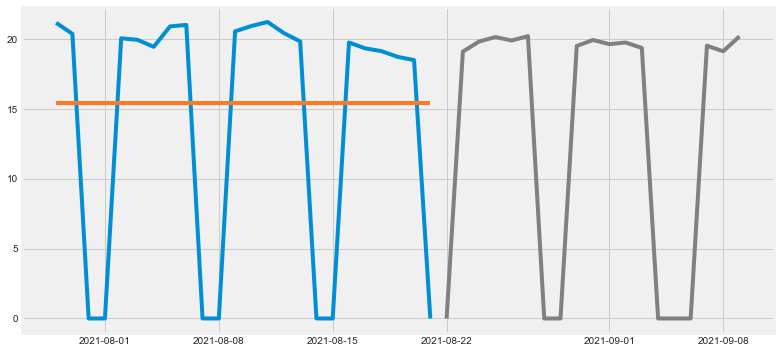

In [9]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['Close']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(18)

fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(18)

fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(18)

fig, ax= plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")

for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();


In [10]:
mse1 = ((pred1 - test['Close']) ** 2).mean()
mse1

ValueError: operands could not be broadcast together with shapes (18,) (19,) 

In [11]:
mse2 = ((pred2 - test['Close']) ** 2).mean()
mse2

ValueError: operands could not be broadcast together with shapes (18,) (19,) 

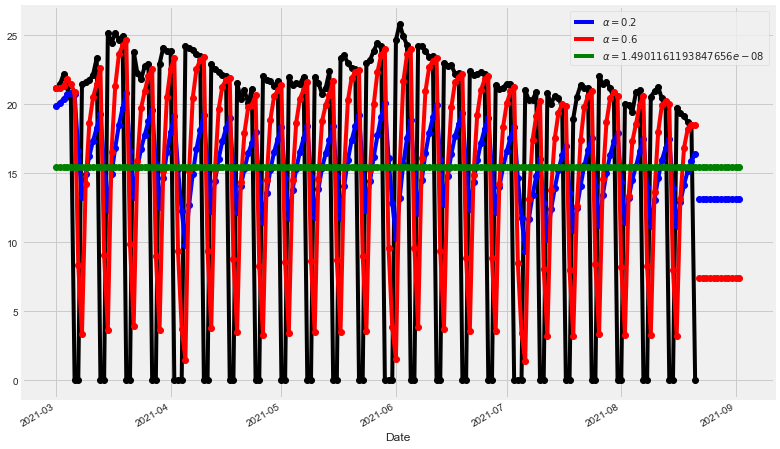

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(train, marker="o", color="black")

fit1 = SimpleExpSmoothing(train ,initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')


fit2 = SimpleExpSmoothing(train).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
# plot
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')


fit3 = SimpleExpSmoothing(train).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

plt.show()

### Holt’s

* Trend in data, No seasonality.
* Data has a trend. Use the multiplicative version, unless the data has been logged before. In this case, use the additive version

ValueError: x and y must have same first dimension, but have shapes (19,) and (18,)

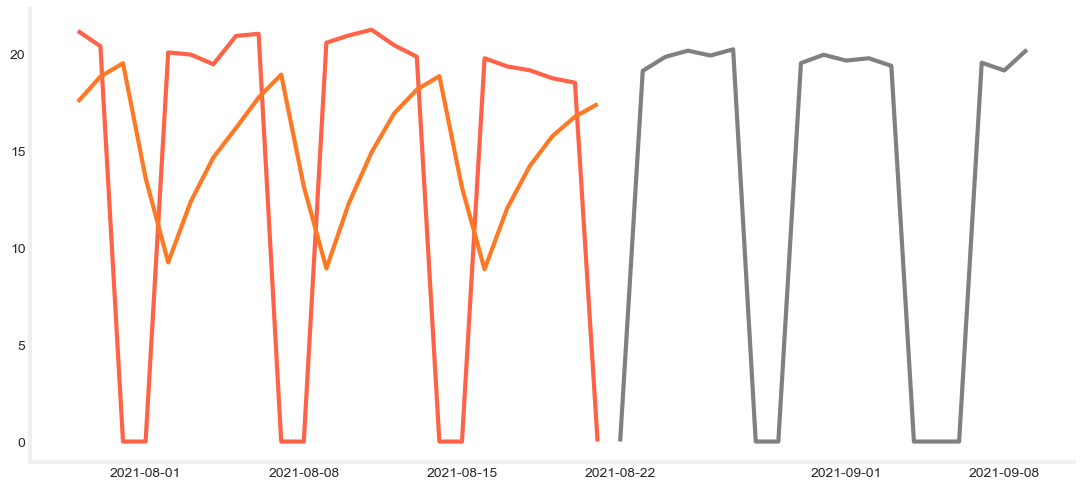

In [13]:
#Holt's linear smoothing
model = Holt(np.asarray(train['Close']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_trend=.05)
pred1 = fit1.forecast(18)

fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(18)

fit3 = model.fit(smoothing_level=.3, smoothing_trend=.2)
pred3 = fit3.forecast(18)

with plt.style.context('images/presentation.mplstyle'):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train.index[150:], train.values[150:])
    ax.plot(test.index, test.values, color="gray")
    for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
        ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
        ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
    plt.title("Holt's Exponential Smoothing")
    plt.legend();

#plt.savefig('images/exsmoothing.png')

In [14]:
fit1.summary()

Dep. Variable:,endog,No. Observations:,174
Model:,Holt,SSE,23163.741
Optimized:,True,AIC,859.084
Trend:,Additive,BIC,871.720
Seasonal:,None,AICC,859.587
Seasonal Periods:,None,Date:,"Fri, 10 Sep 2021"
Box-Cox:,False,Time:,00:28:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_trend,0.0500000,beta,False


### Holt’s Damped Trend

ValueError: x and y must have same first dimension, but have shapes (19,) and (18,)

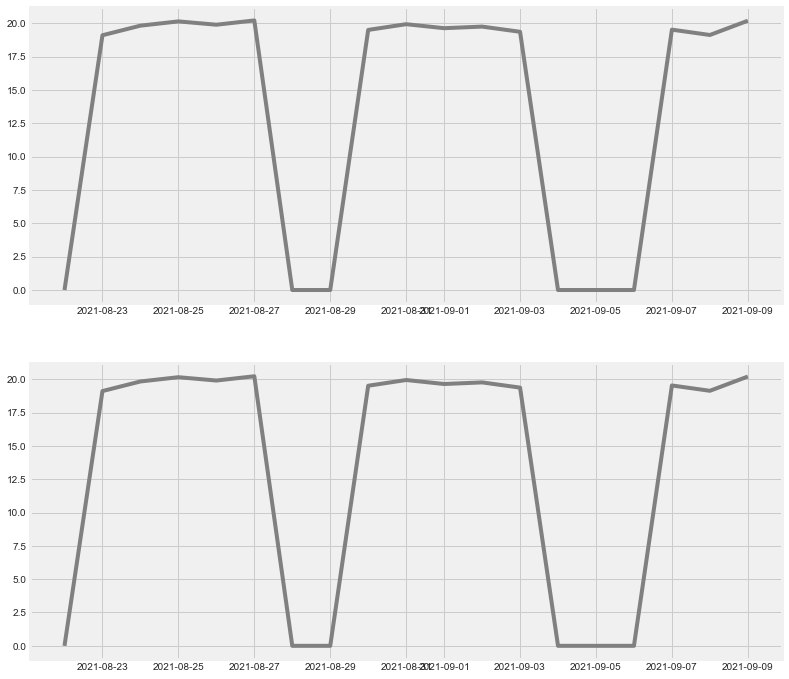

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

model = ExponentialSmoothing(np.asarray(train['Close']), trend='add', seasonal=None)
model2 = ExponentialSmoothing(np.asarray(train['Close']), trend='add', seasonal=None, damped=True)
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
fit2 = model2.fit()
pred1 = fit1.forecast(18)
pred2 = fit2.forecast(18)

fig, ax = plt.subplots(2, figsize=(12, 12))
ax[0].plot(train.index[250:], train.values[250:])
ax[0].plot(test.index, test.values, color="gray", label="truth")
ax[1].plot(train.index[300:], train.values[300:])
ax[1].plot(test.index, test.values, color="gray", label="truth")
for p, f, c in zip((pred1, pred2),(fit1, fit2),('#ff7823','#3c763d')):
    ax[0].plot(train.index[250:], f.fittedvalues[250:], color=c)
    ax[1].plot(train.index[300:], f.fittedvalues[300:], color=c)
    ax[0].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
    ax[1].plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
ax[0].set_title("Damped Exponential Smoothing");
ax[1].set_title("Damped Exponential Smoothing - zoomed");
plt.legend();

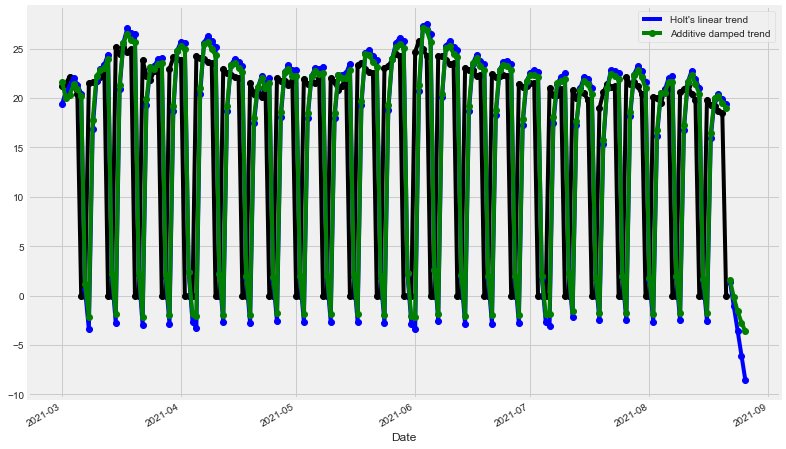

In [16]:
fit1 = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")
#fit2 = Holt(air, exponential=True, initialization_method="estimated").fit(
    #smoothing_level=0.8, smoothing_trend=0.2, optimized=False
#)
#fcast2 = fit2.forecast(5).rename("Exponential trend")
fit3 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast3 = fit3.forecast(5).rename("Additive damped trend")

plt.figure(figsize=(12, 8))
plt.plot(train, marker="o", color="black")
fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)
#fit2.fittedvalues.plot(marker="o", color='red')
#fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)

plt.show()


In [17]:
fit1 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast1 = fit1.forecast(12).rename("SES")
fit2 = Holt(train, initialization_method="estimated").fit()
fcast2 = fit2.forecast(12).rename("Holt's")
#fit3 = Holt(train, exponential=True, initialization_method="estimated").fit()
#fcast3 = fit3.forecast(12).rename("Exponential")
fit4 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    damping_trend=0.98
)
fcast4 = fit4.forecast(12).rename("Additive Damped")
#fit5 = Holt(train, exponential=True, damped_trend=True, initialization_method="estimated").fit()
#fcast5 = fit5.forecast(12).rename("Multiplicative Damped")
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$", "SSE"],
    columns=["SES", "Holt's", "Exponential", "Additive", "Multiplicative"],
)
results["SES"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] = [fit2.params[p] for p in params] + [fit2.sse]
#results["Exponential"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] = [fit4.params[p] for p in params] + [fit4.sse]
#results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results

,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,1.490116e-08,0.000339,NaN,1.490116e-08,NaN
$\beta$,NaN,0.000251,NaN,8.174229e-09,NaN
$\phi$,NaN,NaN,NaN,9.800000e-01,NaN
$l_0$,1.544966e+01,16.676982,NaN,1.736499e+01,NaN
$b_0$,NaN,-0.014028,NaN,-5.378345e-02,NaN
SSE,1.799106e+04,17910.762174,NaN,1.791299e+04,NaN


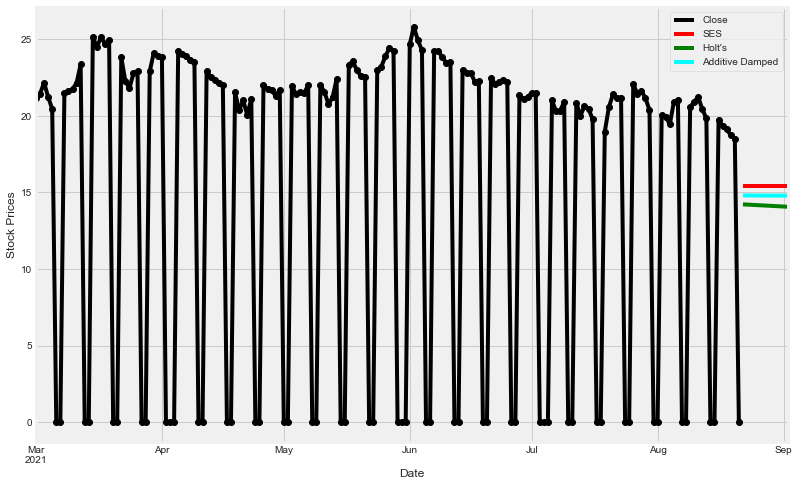

comparing forecasting performance of non-seasonal methods.


In [18]:
ax = train.plot(color="black", marker="o", figsize=(12, 8))
fcast1.plot(ax=ax, color="red", legend=True)
fcast2.plot(ax=ax, color="green", legend=True)
#fcast3.plot(ax=ax, color="blue", legend=True)
fcast4.plot(ax=ax, color="cyan", legend=True)
#fcast5.plot(ax=ax, color="magenta", legend=True)
ax.set_ylabel("Stock Prices")
plt.show()
print(
    "comparing forecasting performance of non-seasonal methods."
)

### Holt-Winter’s Seasonal Smoothing model

* Additive method: the seasonal variations are roughly constant throughout the series.
* Multiplicative method: the seasonal variations are changing proportionally to the level of the series.

NameError: name 'sse1' is not defined

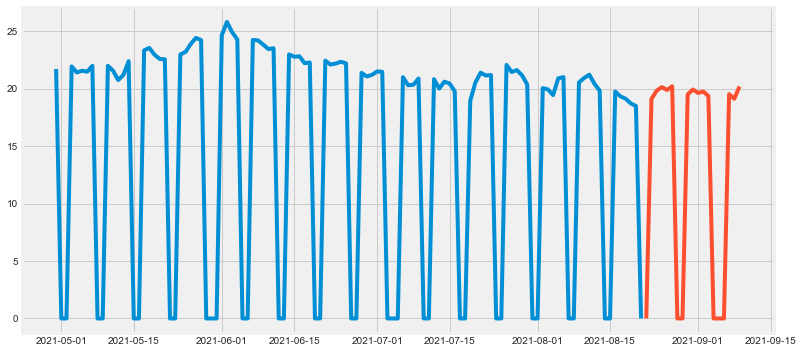

In [19]:

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(18)
fit2 = model2.fit()
pred2 = fit2.forecast(18)

#sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
#sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [ ]:
fit1 = ExponentialSmoothing(
    train,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    train,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    train,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    train,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()
print(
    "Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality."
)

results

In [20]:
states1 = pd.DataFrame(
    np.c_[fit1.level, fit1.trend, fit1.season],
    columns=["level", "slope", "seasonal"],
    index=aust.index,
)
states2 = pd.DataFrame(
    np.c_[fit2.level, fit2.trend, fit2.season],
    columns=["level", "slope", "seasonal"],
    index=aust.index,
)
fig, [[ax1, ax4], [ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(12, 8))
states1[["level"]].plot(ax=ax1)
states1[["slope"]].plot(ax=ax2)
states1[["seasonal"]].plot(ax=ax3)
states2[["level"]].plot(ax=ax4)
states2[["slope"]].plot(ax=ax5)
states2[["seasonal"]].plot(ax=ax6)
plt.show()

NameError: name 'aust' is not defined

### Manual Grid Search comparing RMSE

In [21]:
df = DataReader('AAL', data_source='yahoo', start='2020-03-01', end=datetime.now())

In [22]:
data = df.filter(['Close'])

In [23]:
dataset = data.values

In [24]:
training_data_len = int(np.ceil( len(dataset) * .9 ))

In [25]:
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = np.array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [26]:
fit1 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit2 = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red')
fit2.fittedvalues.plot(style='--', color='green')

fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)

plt.show()
print("Forecasting sales of properties using Holt-Winters method with additive seasonality.")

ValueError: Data must be positive.

In [27]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 

In [28]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [29]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error
 

In [30]:
#Trend:
t= 'mul'
#Damped: 
d= False
#Seasonal: 
s= None
#Seasonal Periods: 
p= None
#Box-Cox Transform: 
b= True
#Remove Bias: 
r= True

cfg = t,d,s,p,b,r 

#t_params = ['add', 'mul', None]
#d_params = [True, False]
#s_params = ['add', 'mul', None]
#p_params = seasonal
#b_params = [True, False]
#r_params = [True, False]


In [31]:
walk_forward_validation(dataset, training_data_len , cfg)

0.7010282757484333

In [32]:
#Trend:
t= 'mul'
#Damped: 
d= False
#Seasonal: 
s= None
#Seasonal Periods: 
p= None
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False

cfg_trend = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len , cfg_trend )

0.7076132506929286

In [33]:
#Trend:
t= None
#Damped: 
d= False
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False

cfg_sea = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len , cfg_sea )

0.7777096322664552

In [34]:
#Trend:
t= None
#Damped: 
d= False
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= True

cfg_sea2 = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len ,cfg_sea2)

0.7841125488410104

In [35]:
#Trend:
t= 'add'
#Damped: 
d= False
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False 


cfg_both = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len ,cfg_both)

0.7932233530495864

In [36]:
#Trend:
t= 'add'
#Damped: 
d= True 
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False 


cfg_both2 = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len ,cfg_both2)

0.7847387197135387